In [5]:
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Data Loading

In [6]:
biomass_density = pd.read_csv('preprocessed/forecasted.csv')

In [7]:
distance_matrix = pd.read_csv('dataset/Distance_Matrix.csv')

In [8]:
distance_matrix = distance_matrix.drop('Unnamed: 0',axis=1)

In [9]:
biomass_density = biomass_density.drop('Unnamed: 0',axis=1)

In [10]:
distance_matrix.shape

(2418, 2418)

## Prprocessing

In [11]:
#new_distance = lambda den,dist: den/dist

In [12]:
biomass_density.head()

,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,24.66818,71.33144,0.212466,0.225726,0.219358,0.169677,0.231301,0.205046,0.243113,0.180307,0.199934,0.502740
1,24.66818,71.41106,0.300711,0.333306,0.309579,0.259861,0.340509,0.328613,0.428428,0.362593,0.334189,0.518164
2,24.66818,71.49069,0.370192,0.440955,0.402816,0.350319,0.433291,0.380620,0.486443,0.435923,0.397611,0.511109
3,24.66818,71.57031,0.407901,0.471496,0.449079,0.371401,0.475138,0.449872,0.525324,0.485404,0.437328,0.541641
4,24.66818,71.64994,0.255002,0.292657,0.292995,0.243953,0.281919,0.291840,0.317984,0.309058,0.257460,0.509233


In [13]:
distance_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,2408,2409,2410,2411,2412,2413,2414,2415,2416,2417
0,0.0000,11.3769,20.4557,38.1227,45.3810,54.9915,78.6108,118.6750,102.6639,113.4309,...,683.8771,687.6310,697.3246,669.3962,667.6788,665.5775,662.0291,665.9655,673.2073,681.4235
1,11.3769,0.0000,9.0788,28.9141,36.1724,45.7829,69.4022,78.2329,93.4553,111.1832,...,681.6295,685.3833,695.0769,667.1485,665.4311,663.3298,659.7815,663.7178,670.9596,679.1758
2,20.4557,9.0788,0.0000,22.3791,29.6374,39.2478,62.8671,71.6979,86.9203,111.7859,...,682.2323,685.9861,695.6796,667.7513,666.0339,663.9326,660.3843,664.3206,671.5623,679.7786
3,38.1227,28.9141,22.3791,0.0000,11.8343,23.5413,41.8396,50.6703,65.8927,82.5852,...,681.4226,685.1765,694.8701,666.9417,665.2243,663.1230,659.5746,663.5110,670.7528,678.9690
4,45.3810,36.1724,29.6374,11.8343,0.0000,11.7070,24.3986,33.2293,53.9901,65.1442,...,663.9816,667.7355,677.4291,649.5007,647.7833,645.6820,642.1336,646.0700,653.3118,661.5280


## Modelling

In [14]:
year = '2018'

### Get initial point with most density of biomass

In [15]:
def get_most(column_name):
    density=biomass_density[column_name]
    return np.argmax(density)
    

### Get pobability based on biomass density

In [16]:
k=10

In [17]:
def set_prob_depots(density):
    sum_density=sum(density)
    prob=[x/sum_density for x in density]
    return prob

In [18]:
weights=set_prob_depots(biomass_density[year])

In [19]:
def get_depots(k,year,weights):
    depots=[]
    while len(depots)!=k :
        depots = np.random.choice(biomass_density[year].shape[0],size=k,p=weights)
    return list(depots)

In [20]:
biomass_density[year].shape[0]

2418

In [21]:
depots = get_depots(k,year,weights)

### Visualising Data

In [22]:
def plot_depots(depots,clusters=None,refineries=None):
    depots_location = biomass_density.loc[depots, ["Latitude", "Longitude"]]

    latitudes = biomass_density["Latitude"]
    longitudes = biomass_density["Longitude"]

    # Create a scatter plot
    plt.scatter(latitudes, longitudes,c=clusters)
    if(refineries!=None):
        refineries_location = biomass_density.loc[refineries, ["Latitude", "Longitude"]]
        plt.scatter(refineries_location['Latitude'],refineries_location['Longitude'],marker='o', color='white')
    
    plt.scatter(depots_location["Latitude"], depots_location["Longitude"], marker='x', color='red')

    # Add a title and labels
    plt.title('Latitude and Longitude')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')

    # Show the plot
    plt.show()

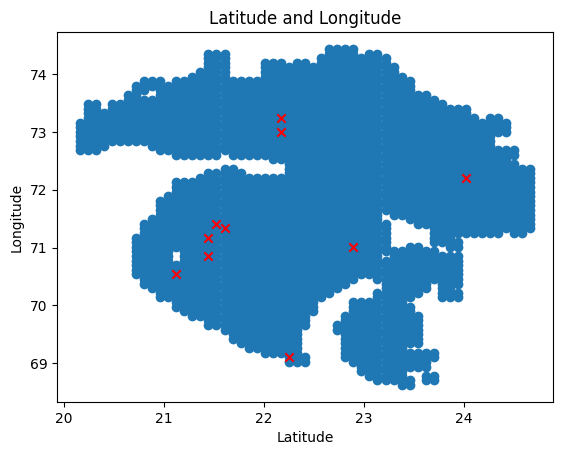

In [23]:
plot_depots(depots)

## Optimal clusters for depots

In [24]:
def re_cluster_depots(k,X,depots):
    belonging_to_cluster=np.array([])
    for i in range(X.shape[0]):
        distance=[distance_matrix.iloc[i,x] for x in depots]
        belonging_to_cluster=np.append(belonging_to_cluster,np.argmin(distance))

    depots = []
    for i in range(k):
        if len(X[belonging_to_cluster==i][['Latitude','Longitude']]) != 0:
            pseudo_coord = np.mean(X[belonging_to_cluster==i][['Latitude','Longitude']].to_numpy(),axis=0)
            distance = [np.linalg.norm(pseudo_coord - x) for x in X[belonging_to_cluster==i][['Latitude','Longitude']].to_numpy()]
            depots.append(X[belonging_to_cluster==i].iloc[np.argmin(distance),:].name)
        else:
            depots = get_depots(k,year,weights)
            re_cluster_depots(k,X,depots)
        
    return depots,belonging_to_cluster

In [25]:
count=0
clusters=[]
for _ in range(30):
    prev=depots
    depots,clusters=re_cluster_depots(k,biomass_density,depots)
    if np.array_equal(prev,depots):
        break
    print(depots)
    count+=1
print(f"Convergence in : {count} iterations")

[1745, 791, 1505, 2171, 2161, 1669, 261, 1286, 1644, 1761]
[1690, 723, 1505, 2170, 2161, 1886, 261, 1010, 1464, 1762]
[1635, 590, 1505, 2128, 2161, 2053, 219, 1014, 1210, 1709]
[1577, 588, 1505, 2081, 2162, 2148, 218, 1016, 1099, 1654]
[1516, 588, 1505, 2081, 2161, 2148, 218, 1016, 1046, 1654]
[1456, 588, 1566, 2081, 2116, 2148, 218, 1017, 992, 1654]
[1393, 588, 1566, 2081, 2116, 2148, 218, 1072, 993, 1595]
[1327, 588, 1566, 2081, 2069, 2189, 218, 1072, 932, 1595]
[1262, 588, 1566, 2081, 2069, 2189, 218, 1072, 933, 1595]
[1262, 588, 1566, 2081, 2069, 2189, 179, 1072, 934, 1595]
[1262, 588, 1566, 2081, 2069, 2189, 179, 1072, 935, 1595]
[1204, 588, 1566, 2081, 2069, 2189, 179, 1072, 935, 1595]
[1204, 588, 1567, 2081, 2069, 2189, 179, 1072, 936, 1595]
[1204, 588, 1567, 2081, 2019, 2189, 179, 1073, 873, 1595]
[1204, 588, 1567, 2081, 2019, 2189, 179, 1073, 874, 1595]
[1205, 588, 1567, 2081, 2019, 2189, 179, 1073, 876, 1653]
[1149, 588, 1567, 2081, 2019, 2189, 179, 1073, 877, 1653]
[1150, 58

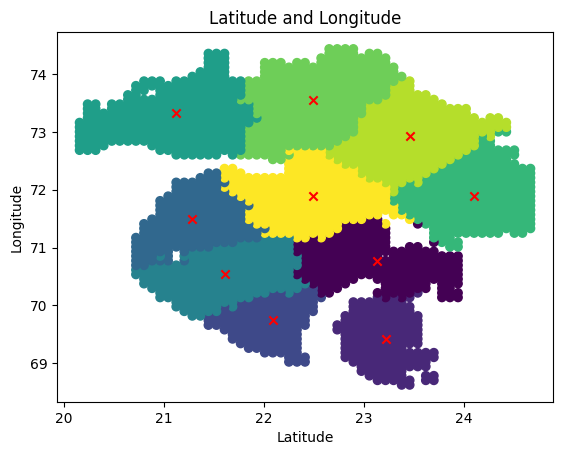

In [26]:
plot_depots(depots,clusters)

## Finding refineries

In [27]:
biomass_density

,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,24.66818,71.33144,0.212466,0.225726,0.219358,0.169677,0.231301,0.205046,0.243113,0.180307,0.199934,0.502740
1,24.66818,71.41106,0.300711,0.333306,0.309579,0.259861,0.340509,0.328613,0.428428,0.362593,0.334189,0.518164
2,24.66818,71.49069,0.370192,0.440955,0.402816,0.350319,0.433291,0.380620,0.486443,0.435923,0.397611,0.511109
3,24.66818,71.57031,0.407901,0.471496,0.449079,0.371401,0.475138,0.449872,0.525324,0.485404,0.437328,0.541641
4,24.66818,71.64994,0.255002,0.292657,0.292995,0.243953,0.281919,0.291840,0.317984,0.309058,0.257460,0.509233
...,...,...,...,...,...,...,...,...,...,...,...,...
2413,20.15456,72.84432,0.180534,0.180260,0.170496,0.129193,0.180347,0.190154,0.231986,0.181932,0.177813,0.534950
2414,20.15456,72.92394,0.051700,0.054713,0.048782,0.044817,0.051860,0.054145,0.065674,0.051462,0.048789,0.564789
2415,20.15456,73.00357,0.035414,0.037422,0.033379,0.030625,0.035525,0.037108,0.044995,0.035245,0.034098,0.564997
2416,20.15456,73.08319,0.145447,0.121111,0.097915,0.099246,0.114721,0.119751,0.145269,0.113851,0.120770,0.528472


In [28]:
def biomass_per_depo(k,clusters,year):
    biomass=[]
    for i in range(k):
        biomass.append(sum(biomass_density[clusters==i][year]))
        #print(biomass)
    return biomass

In [29]:
biomass_per_depot=biomass_per_depo(k,clusters,year)
biomass_per_depot

[114.50884625300003,
 38.62904818029999,
 62.55255163399999,
 117.22168491399998,
 154.975623381,
 122.14497614499999,
 123.29561237000001,
 148.481975312,
 138.01571455999996,
 155.06761239399995]

In [30]:
depots

[728, 645, 1506, 2083, 1852, 2190, 150, 1239, 500, 1218]

In [31]:
r=5

In [32]:
def set_prob_ref(density):
    sum_density = sum(density)
    prob = [x/sum_density for x in density]
    return prob

In [33]:
biomass_per_depot

[114.50884625300003,
 38.62904818029999,
 62.55255163399999,
 117.22168491399998,
 154.975623381,
 122.14497614499999,
 123.29561237000001,
 148.481975312,
 138.01571455999996,
 155.06761239399995]

In [34]:
weights=set_prob_ref(biomass_per_depot)
weights

[0.09746315909218624,
 0.032878761698969326,
 0.05324103325656388,
 0.0997721669519309,
 0.1319060870076439,
 0.10396258133654486,
 0.10494193485484539,
 0.12637907773676815,
 0.11747081544829227,
 0.1319843826162551]

In [35]:
def get_refineries(r,depots,weights):
    if len(weights)<r:
        r = len(weights)
    refineries_index = np.random.choice(len(weights),size=r,p=weights)
    #print(refineries_index)
    refineries = []
    for i in refineries_index:
        refineries.append(depots[i])
    return refineries

In [36]:
get_refineries(5,depots,weights)

[1239, 2190, 150, 150, 2190]

In [37]:
refineries = get_refineries(r,depots,weights)
refineries

[1218, 1218, 1239, 500, 1218]

## Optimal clusters for refineries

In [38]:
def re_cluster_refineries(r,X,refineries):
    belonging_to_cluster=np.array([])
    for i in X:
        distance = [distance_matrix.iloc[i,x] for x in refineries]
        belonging_to_cluster = np.append(belonging_to_cluster,np.argmin(distance))
        
    X=np.array(X)
    refineries = []
    for i in range(r):
        if len(biomass_density.iloc[X[belonging_to_cluster==i],[0,1]].to_numpy()) != 0:
            pseudo_coord = np.mean(biomass_density.iloc[X[belonging_to_cluster==i],[0,1]].to_numpy(), axis=0)
            distance = [np.linalg.norm(pseudo_coord - x) for x in biomass_density.iloc[:,[0,1]].to_numpy()]
            refineries.append(biomass_density.iloc[np.argmin(distance),:].name)
        else:
            refineries = get_refineries(r,depots,weights)
            re_cluster_refineries(r,X,refineries)
    return refineries,belonging_to_cluster

In [39]:
count=0
clusters_depots=[]
for _ in range(30):
    prev=refineries
    refineries,cluster_depots=re_cluster_refineries(r,depots,refineries)
    if np.array_equal(prev,refineries):
        break
    # print(refineries)
    count+=1
print(f"Convergence in : {count} iterations")

Convergence in : 16 iterations


In [40]:
def biomass_per_refineries(r,cluster_depots,biomass_per_depot):
    biomass=[]
    biomass_per_depot=np.array(biomass_per_depot)
    for i in range(r):
        biomass.append(sum(biomass_per_depot[cluster_depots==i]))
    return biomass

In [41]:
biomass_per_refinery = biomass_per_refineries(r,cluster_depots,biomass_per_depot)

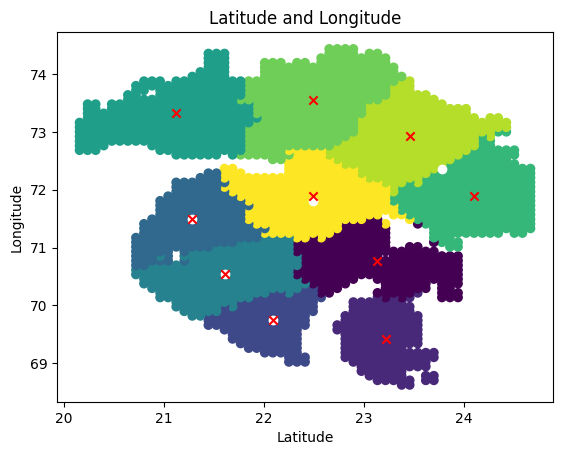

In [42]:
plot_depots(depots,clusters,refineries)

## Loss function for depots

In [43]:
biomass_per_depot

[114.50884625300003,
 38.62904818029999,
 62.55255163399999,
 117.22168491399998,
 154.975623381,
 122.14497614499999,
 123.29561237000001,
 148.481975312,
 138.01571455999996,
 155.06761239399995]

In [44]:
biomass_per_refinery

[62.55255163399999,
 261.31132692999995,
 578.8324582843,
 154.975623381,
 117.22168491399998]

In [45]:
clusters

array([6., 6., 6., ..., 5., 5., 5.])

In [46]:
cluster_depots

array([2., 2., 0., 4., 3., 2., 1., 2., 1., 2.])

In [47]:
depots

[728, 645, 1506, 2083, 1852, 2190, 150, 1239, 500, 1218]

In [48]:
refineries

[1506, 302, 1217, 1852, 2083]

In [49]:
def loss_depot(depots,year):
    loss=[]
    for i in range(len(depots)):
        loss.append(sum([biomass_density.loc[x,year]*distance_matrix.iloc[x,depots[i]] for x in biomass_density[clusters==i].index]))
    #print(loss)
    return sum(loss)

In [50]:
def loss_refinery(refineries,cluster_depots,depots):
    loss=[]
    refineries=np.array(refineries)
    depots = np.array(depots)
    for i in range(len(refineries)):
        loss.append(sum([biomass_per_depot[x]*distance_matrix.iloc[depots[x],refineries[i]] for x in np.where(depots[cluster_depots==i])[0]]))
    #print(loss)
    return sum(loss)

In [51]:
loss_depot(depots,year)

84730.68206292288

In [52]:
loss_refinery(refineries,cluster_depots,depots)

226930.70262954803

### Optimal number for depots (2018)

In [53]:
k=range(1,26)

Convergence in : 1 iterations


Convergence in : 7 iterations
Convergence in : 5 iterations
Convergence in : 11 iterations
Convergence in : 10 iterations
Convergence in : 7 iterations
Convergence in : 20 iterations
Convergence in : 7 iterations
Convergence in : 25 iterations
Convergence in : 12 iterations
Convergence in : 6 iterations
Convergence in : 7 iterations
Convergence in : 18 iterations
Convergence in : 9 iterations
Convergence in : 7 iterations
Convergence in : 12 iterations
Convergence in : 30 iterations
Convergence in : 16 iterations
Convergence in : 12 iterations
Convergence in : 12 iterations
Convergence in : 7 iterations
Convergence in : 8 iterations
Convergence in : 9 iterations
Convergence in : 9 iterations
Convergence in : 8 iterations


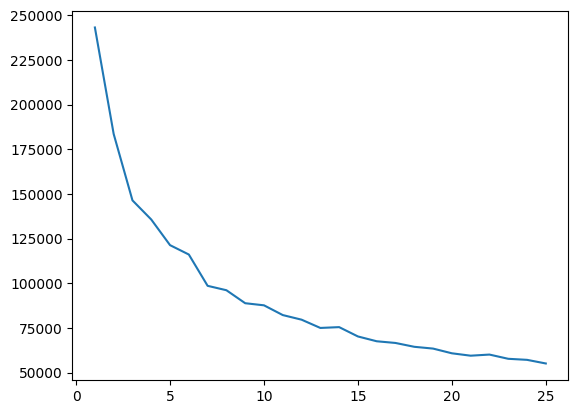

In [54]:
loss_d=[]
for i in k:
    year = '2018'
    weights = set_prob_depots(density=biomass_density[year])
    depots = get_depots(i,year,weights)
    
    count=0
    clusters=[]
    for _ in range(30):
        prev=depots
        depots,clusters=re_cluster_depots(i,biomass_density,depots)
        if np.array_equal(prev,depots):
            break
        #print(depots)
        count+=1
    loss_d.append(loss_depot(depots,year))
    print(f"Convergence in : {count} iterations")
plt.plot(k,loss_d)

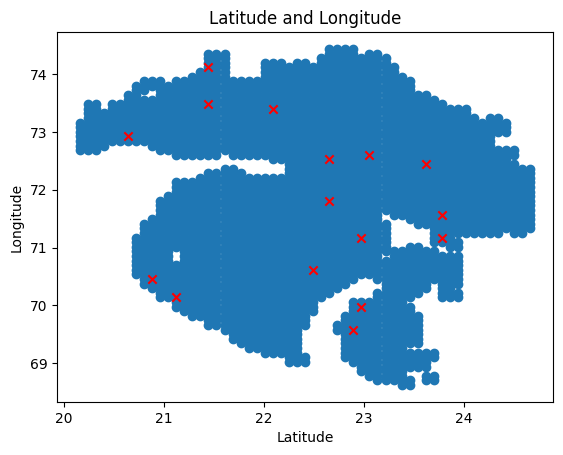

In [55]:
k = 16
weights = set_prob_depots(density=biomass_density[year])
depots = get_depots(k,year,weights)
plot_depots(depots)

In [56]:
count=0
clusters=[]
for _ in range(30):
    prev=depots
    depots,clusters=re_cluster_depots(k,biomass_density,depots)
    if np.array_equal(prev,depots):
        break
    print(depots)
    count+=1
print(f"Convergence in : {count} iterations")

[2355, 1846, 2109, 1171, 224, 927, 1391, 654, 148, 1997, 2210, 688, 643, 1532, 1299, 284]
[2356, 1792, 2108, 1171, 225, 928, 1391, 655, 148, 1939, 2168, 624, 643, 1652, 1242, 324]
[2356, 1791, 2107, 1116, 266, 929, 1391, 655, 149, 1882, 2126, 564, 643, 1652, 1187, 324]
[2355, 1791, 2154, 1116, 266, 929, 1392, 655, 149, 1830, 2125, 564, 643, 1707, 1132, 324]
[2355, 1736, 2154, 1062, 266, 930, 1392, 655, 149, 1775, 2124, 564, 643, 1707, 1132, 324]
[2355, 1736, 2154, 1062, 266, 931, 1393, 655, 124, 1775, 2124, 565, 643, 1707, 1132, 324]
[2355, 1736, 2154, 1062, 266, 932, 1327, 656, 124, 1775, 2124, 565, 643, 1707, 1132, 324]
[2355, 1682, 2154, 1062, 266, 932, 1328, 657, 124, 1775, 2124, 565, 643, 1761, 1132, 283]
[2355, 1682, 2154, 1062, 266, 932, 1328, 657, 124, 1775, 2123, 565, 643, 1761, 1132, 284]
[2355, 1627, 2154, 1062, 266, 932, 1328, 657, 124, 1775, 2122, 565, 643, 1815, 1132, 284]
[2355, 1627, 2154, 1062, 266, 932, 1329, 657, 124, 1775, 2122, 565, 643, 1815, 1132, 284]
[2355, 162

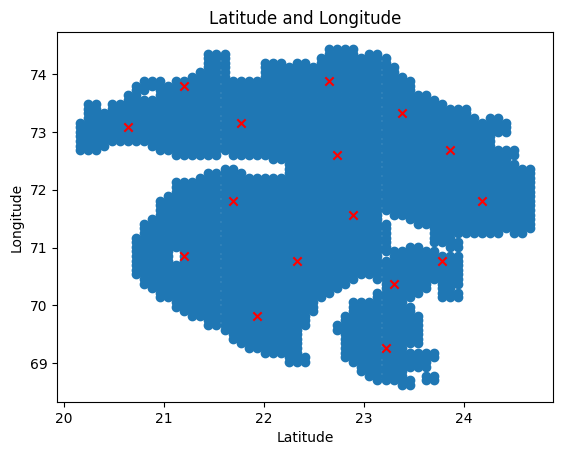

In [57]:
plot_depots(depots)

### Optimal Number of refineries (2018)

In [58]:
r = range(1,6)

Convergence in : 1 iterations
Convergence in : 3 iterations
Convergence in : 3 iterations
Convergence in : 3 iterations
Convergence in : 3 iterations


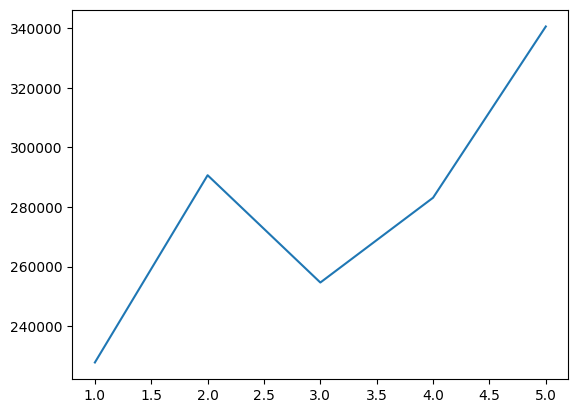

In [59]:
loss_r=[]
for i in r:
    year = '2018'
    biomass_per_depot = biomass_per_depo(k,clusters,year)
    weights = set_prob_ref(biomass_per_depot)
    #print(weights)
    refineries = get_refineries(i,depots,weights)
    
    count=0
    clusters_depots=[]
    for _ in range(30):
        prev=refineries
        refineries,clusters_depots = re_cluster_refineries(i,depots,refineries)
        if np.array_equal(prev,refineries):
            break
        #print(refineries)
        count+=1
    loss_r.append(loss_refinery(refineries,clusters_depots,depots))
    print(f"Convergence in : {count} iterations")
plt.plot(list(r),loss_r)

In [60]:
r = 4

In [61]:
weights=set_prob_ref(biomass_per_depot)
refineries = get_refineries(r,depots,weights)

In [62]:
count=0
clusters_depots=[]
for _ in range(30):
    prev=refineries
    refineries,cluster_depots=re_cluster_refineries(r,depots,refineries)
    if np.array_equal(prev,refineries):
        break
    # print(refineries)
    count+=1
print(f"Convergence in : {count} iterations")

Convergence in : 4 iterations


In [63]:
biomass_per_refinery = biomass_per_refineries(r,cluster_depots,biomass_per_depot)

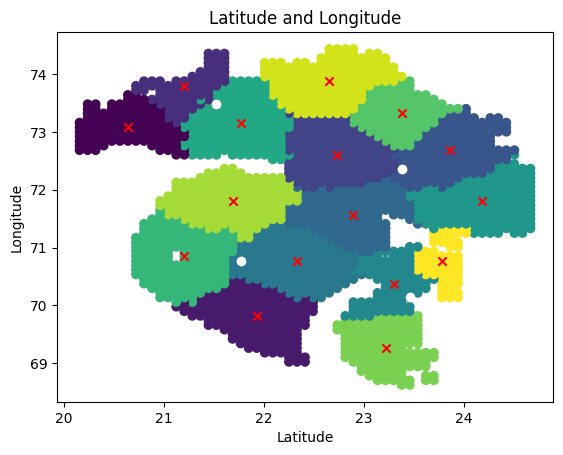

In [64]:
plot_depots(depots,clusters,refineries)

### Optimal number for depots (2019)

In [65]:
k=range(1,26)

In [66]:
year = '2019'

Convergence in : 1 iterations
Convergence in : 8 iterations
Convergence in : 9 iterations
Convergence in : 7 iterations
Convergence in : 3 iterations
Convergence in : 7 iterations
Convergence in : 7 iterations
Convergence in : 14 iterations
Convergence in : 12 iterations
Convergence in : 17 iterations
Convergence in : 10 iterations
Convergence in : 9 iterations
Convergence in : 13 iterations
Convergence in : 11 iterations
Convergence in : 10 iterations
Convergence in : 23 iterations
Convergence in : 7 iterations
Convergence in : 30 iterations
Convergence in : 5 iterations
Convergence in : 20 iterations
Convergence in : 18 iterations
Convergence in : 23 iterations
Convergence in : 14 iterations
Convergence in : 14 iterations
Convergence in : 15 iterations


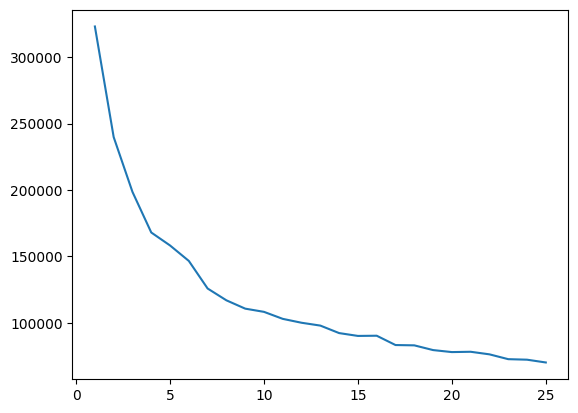

In [67]:
loss_d=[]
for i in k:
    year = '2019'
    weights = set_prob_depots(density=biomass_density[year])
    depots = get_depots(i,year,weights)
    
    count=0
    clusters=[]
    for _ in range(30):
        prev=depots
        depots,clusters=re_cluster_depots(i,biomass_density,depots)
        if np.array_equal(prev,depots):
            break
        #print(depots)
        count+=1
    loss_d.append(loss_depot(depots,year))
    print(f"Convergence in : {count} iterations")
plt.plot(k,loss_d)

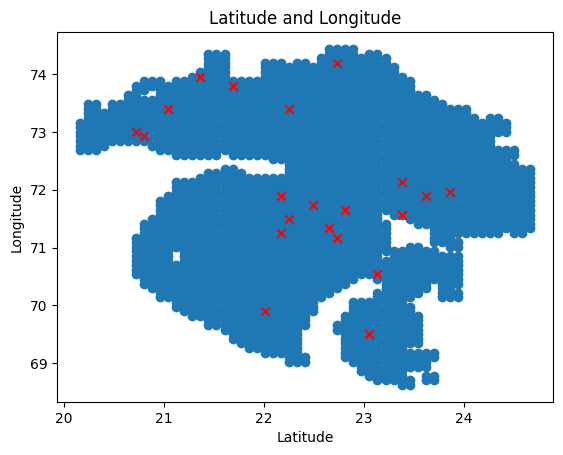

In [68]:
k = 21
weights = set_prob_depots(density=biomass_density[year])
depots = get_depots(k,year,weights)
plot_depots(depots)

In [69]:
count=0
clusters=[]
for _ in range(30):
    prev=depots
    depots,clusters=re_cluster_depots(k,biomass_density,depots)
    if np.array_equal(prev,depots):
        break
    print(depots)
    count+=1
print(f"Convergence in : {count} iterations")

[129, 2061, 1164, 1915, 899, 934, 1738, 2142, 2230, 986, 644, 604, 1528, 1154, 475, 1886, 616, 1360, 2375, 380, 1763]
[103, 2061, 1166, 2076, 898, 934, 1683, 2142, 2268, 984, 644, 606, 1527, 1209, 419, 1833, 499, 1360, 2375, 293, 1870]
[103, 2007, 1167, 2122, 961, 995, 1627, 2142, 2268, 983, 644, 548, 1586, 1265, 419, 1833, 445, 1360, 2375, 211, 1926]
[103, 2006, 1167, 2121, 961, 994, 1627, 2142, 2268, 984, 644, 549, 1644, 1330, 419, 1833, 446, 1360, 2375, 210, 1983]
[104, 2061, 1167, 2165, 962, 994, 1627, 2142, 2268, 922, 644, 549, 1645, 1394, 419, 1833, 447, 1360, 2375, 171, 1982]
[105, 2007, 1167, 2165, 1024, 993, 1627, 2142, 2268, 922, 644, 550, 1700, 1393, 419, 1833, 447, 1359, 2375, 145, 1982]
[106, 2006, 1167, 2205, 1024, 1048, 1627, 2142, 2268, 923, 644, 550, 1753, 1392, 419, 1833, 448, 1359, 2375, 146, 1983]
[106, 2061, 1167, 2205, 1024, 1103, 1626, 2142, 2268, 923, 644, 550, 1807, 1392, 419, 1833, 448, 1359, 2375, 146, 1983]
[106, 2007, 1168, 2204, 1024, 1103, 1626, 2142, 226

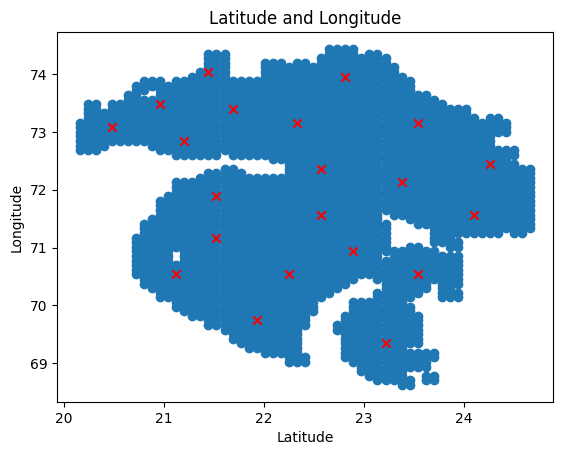

In [70]:
plot_depots(depots)

### Optimal Number of refineries (2019)

In [71]:
r = range(1,6)

Convergence in : 1 iterations


Convergence in : 4 iterations
Convergence in : 2 iterations
Convergence in : 3 iterations
Convergence in : 3 iterations


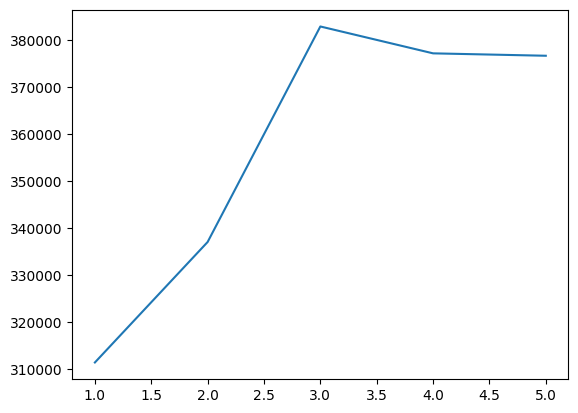

In [72]:
loss_r=[]
for i in r:
    year = '2019'
    biomass_per_depot = biomass_per_depo(k,clusters,year)
    weights = set_prob_ref(biomass_per_depot)
    #print(weights)
    refineries = get_refineries(i,depots,weights)
    
    count=0
    clusters_depots=[]
    for _ in range(30):
        prev=refineries
        refineries,clusters_depots = re_cluster_refineries(i,depots,refineries)
        if np.array_equal(prev,refineries):
            break
        #print(refineries)
        count+=1
    loss_r.append(loss_refinery(refineries,clusters_depots,depots))
    print(f"Convergence in : {count} iterations")
plt.plot(list(r),loss_r)

In [73]:
r=4

In [74]:
weights=set_prob_ref(biomass_per_depot)
refineries = get_refineries(r,depots,weights)

In [75]:
count=0
clusters_depots=[]
for _ in range(30):
    prev=refineries
    refineries,cluster_depots=re_cluster_refineries(r,depots,refineries)
    if np.array_equal(prev,refineries):
        break
    # print(refineries)
    count+=1
print(f"Convergence in : {count} iterations")

Convergence in : 4 iterations


In [76]:
biomass_per_refinery = biomass_per_refineries(r,cluster_depots,biomass_per_depot)

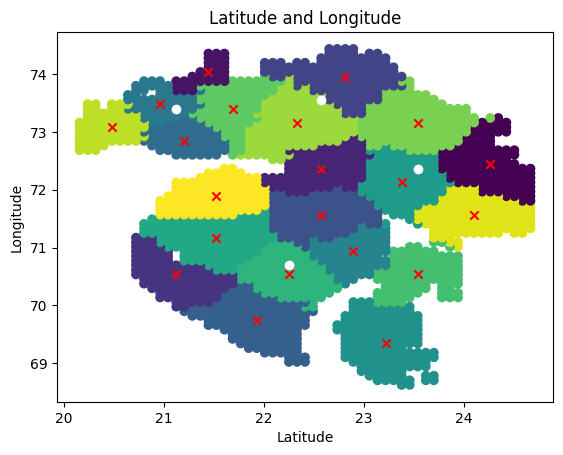

In [77]:
plot_depots(depots,clusters,refineries)

## Combined data for 2018 and 2019

In [79]:
biomass_density['20182019'] = (biomass_density['2018'] + biomass_density['2019']) / 2

In [81]:
biomass_density.head()

,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,20182019
0,24.66818,71.33144,0.212466,0.225726,0.219358,0.169677,0.231301,0.205046,0.243113,0.180307,0.199934,0.502740,0.351337
1,24.66818,71.41106,0.300711,0.333306,0.309579,0.259861,0.340509,0.328613,0.428428,0.362593,0.334189,0.518164,0.426176
2,24.66818,71.49069,0.370192,0.440955,0.402816,0.350319,0.433291,0.380620,0.486443,0.435923,0.397611,0.511109,0.454360
3,24.66818,71.57031,0.407901,0.471496,0.449079,0.371401,0.475138,0.449872,0.525324,0.485404,0.437328,0.541641,0.489485
4,24.66818,71.64994,0.255002,0.292657,0.292995,0.243953,0.281919,0.291840,0.317984,0.309058,0.257460,0.509233,0.383347


### Optimal number for depots (20182019)

In [83]:
k=range(1,26)
year = '20182019'

Convergence in : 1 iterations
Convergence in : 5 iterations
Convergence in : 7 iterations
Convergence in : 19 iterations
Convergence in : 9 iterations
Convergence in : 10 iterations
Convergence in : 9 iterations
Convergence in : 8 iterations
Convergence in : 10 iterations
Convergence in : 13 iterations
Convergence in : 8 iterations
Convergence in : 19 iterations
Convergence in : 10 iterations
Convergence in : 19 iterations
Convergence in : 12 iterations
Convergence in : 17 iterations
Convergence in : 30 iterations
Convergence in : 13 iterations
Convergence in : 8 iterations
Convergence in : 30 iterations
Convergence in : 7 iterations
Convergence in : 30 iterations
Convergence in : 8 iterations
Convergence in : 10 iterations
Convergence in : 12 iterations


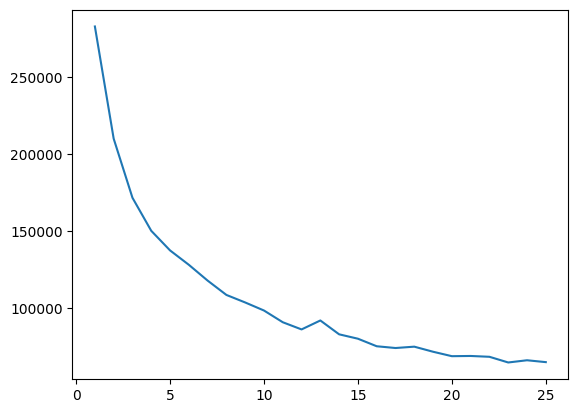

In [84]:
loss_d=[]
for i in k:
    year = '20182019'
    weights = set_prob_depots(density=biomass_density[year])
    depots = get_depots(i,year,weights)
    
    count=0
    clusters=[]
    for _ in range(30):
        prev=depots
        depots,clusters=re_cluster_depots(i,biomass_density,depots)
        if np.array_equal(prev,depots):
            break
        #print(depots)
        count+=1
    loss_d.append(loss_depot(depots,year))
    print(f"Convergence in : {count} iterations")
plt.plot(k,loss_d)

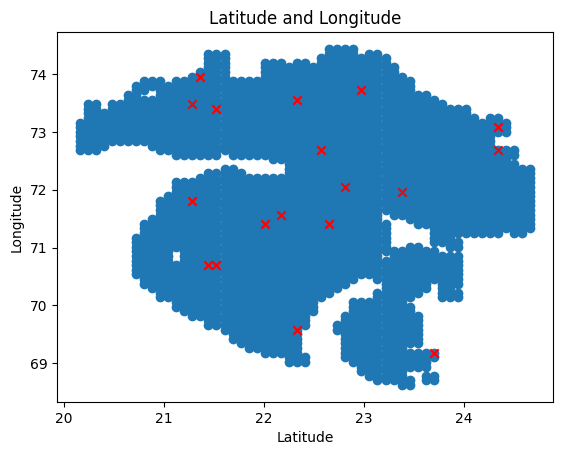

In [85]:
k = 18
weights = set_prob_depots(density=biomass_density[year])
depots = get_depots(k,year,weights)
plot_depots(depots)

In [86]:
count=0
clusters=[]
for _ in range(30):
    prev=depots
    depots,clusters=re_cluster_depots(k,biomass_density,depots)
    if np.array_equal(prev,depots):
        break
    print(depots)
    count+=1
print(f"Convergence in : {count} iterations")

[79, 2322, 862, 1471, 831, 1691, 1882, 2118, 1507, 645, 336, 1430, 1585, 191, 2061, 1001, 2086, 1118]
[78, 2343, 795, 1472, 831, 1690, 1881, 2163, 1506, 645, 291, 1431, 1585, 270, 2060, 939, 2085, 1119]
[78, 2356, 794, 1533, 832, 1689, 1881, 2203, 1505, 645, 249, 1432, 1523, 309, 2108, 810, 2084, 1119]
[79, 2356, 794, 1533, 833, 1743, 1881, 2203, 1505, 645, 207, 1432, 1462, 309, 2107, 809, 2084, 1119]
[102, 2356, 793, 1533, 833, 1743, 1881, 2204, 1505, 645, 206, 1432, 1398, 351, 2107, 743, 2084, 1119]
[101, 2356, 793, 1533, 833, 1797, 1881, 2204, 1505, 645, 245, 1432, 1398, 352, 2107, 743, 2084, 1119]
[101, 2356, 858, 1533, 833, 1797, 1881, 2204, 1505, 645, 285, 1432, 1398, 352, 2107, 743, 2084, 1119]
[100, 2356, 859, 1533, 833, 1797, 1881, 2204, 1505, 645, 325, 1432, 1398, 352, 2107, 742, 2084, 1119]
[125, 2356, 859, 1533, 833, 1797, 1881, 2204, 1505, 645, 324, 1432, 1398, 351, 2107, 742, 2084, 1119]
Convergence in : 9 iterations


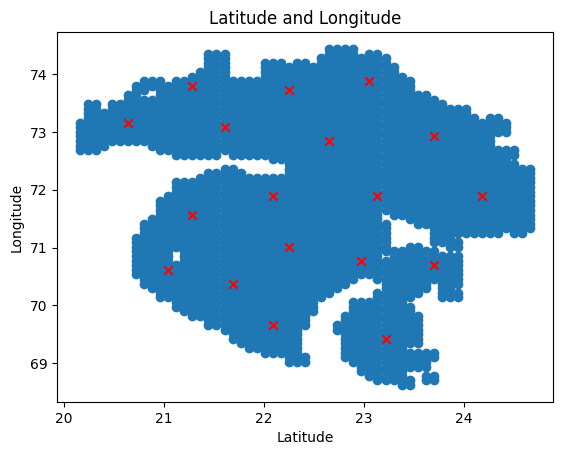

In [87]:
plot_depots(depots)

### Optimal Number of refineries (20182019)

In [88]:
r = range(1,6)

Convergence in : 1 iterations
Convergence in : 3 iterations
Convergence in : 1 iterations
Convergence in : 4 iterations
Convergence in : 4 iterations


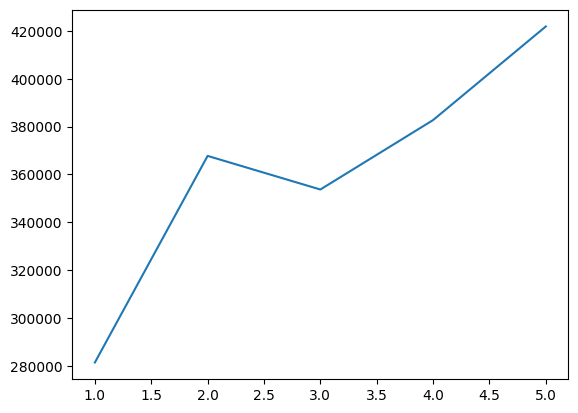

In [98]:
loss_r=[]
for i in r:
    year = '20182019'
    biomass_per_depot = biomass_per_depo(k,clusters,year)
    weights = set_prob_ref(biomass_per_depot)
    #print(weights)
    refineries = get_refineries(i,depots,weights)
    
    count=0
    clusters_depots=[]
    for _ in range(30):
        prev=refineries
        refineries,clusters_depots = re_cluster_refineries(i,depots,refineries)
        if np.array_equal(prev,refineries):
            break
        #print(refineries)
        count+=1
    loss_r.append(loss_refinery(refineries,clusters_depots,depots))
    print(f"Convergence in : {count} iterations")
plt.plot(list(r),loss_r)

In [103]:
r = 3

In [104]:
weights=set_prob_ref(biomass_per_depot)
refineries = get_refineries(r,depots,weights)

In [105]:
count=0
clusters_depots=[]
for _ in range(30):
    prev=refineries
    refineries,cluster_depots=re_cluster_refineries(r,depots,refineries)
    if np.array_equal(prev,refineries):
        break
    # print(refineries)
    count+=1
print(f"Convergence in : {count} iterations")

Convergence in : 2 iterations


In [106]:
biomass_per_refinery = biomass_per_refineries(r,cluster_depots,biomass_per_depot)

In [108]:
biomass_per_refinery

[400.7299972791499, 505.7007788165001, 393.611927636]

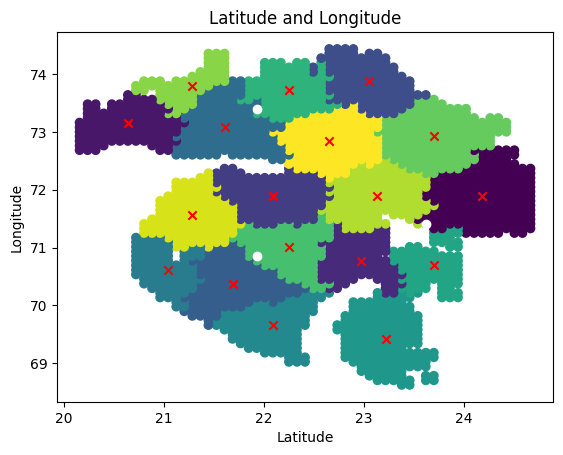

In [109]:
plot_depots(depots,clusters,refineries)